In [163]:
# import libraries

# basics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# nlp

import spacy
import nltk

# Keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Bidirectional,\
                                    Conv1D, MaxPooling1D, Dropout, Activation, Embedding

# preprocessing and model validation

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, FeatureAgglomeration
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,\
                            confusion_matrix, plot_confusion_matrix,\
                            silhouette_score
from sklearn.svm import SVC

%matplotlib inline

In [164]:
# read in the dataset

df = pd.read_json('../data/cleaned/json.json')

In [165]:
# check the data

print(df.shape)
df.head()

(102031, 13)


,subreddit,author,date,post,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,lemmatized,vectors
0,alcoholism,glorybellpirate,2020-01-01,Day 1 of sobriety Feeling anxious and letting ...,0,0,1,0,0,24,3,day 1 of sobriety feel anxious and let the fee...,"[-0.026765203100000003, 0.2515704036, -0.15668..."
1,alcoholism,EhndlessSl0th,2020-01-01,"Started the New Year with a bang. Hey, I'm new...",0,1,1,0,1,577,41,start the new year with a bang hey -pron- be n...,"[0.0102483444, 0.18354494870000002, -0.2263026..."
2,alcoholism,the_kinky_penguin,2020-01-01,Why can't I get drunk anymore I've been a heav...,0,0,1,0,0,64,5,why ca not -pron- get drunk anymore -pron- hav...,"[-0.09739924970000001, 0.1839587241, -0.227181..."
3,alcoholism,SauceoffSauceOn,2020-01-01,I am an Alcoholic. How do I quit? I have been ...,0,0,1,0,1,111,14,-pron- be an alcoholic how do -pron- quit -pro...,"[-0.0117096035, 0.1865714192, -0.2576603591, -..."
4,alcoholism,ben42187,2020-01-01,Funniest Thing about Alcoholism With every oth...,0,0,1,0,0,136,9,funniest thing about alcoholism with every oth...,"[-0.0443742387, 0.1812106818, -0.1554362029000..."


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102031 entries, 0 to 102030
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   subreddit      102031 non-null  object        
 1   author         102031 non-null  object        
 2   date           102031 non-null  datetime64[ns]
 3   post           102031 non-null  object        
 4   covid_related  102031 non-null  int64         
 5   suicidal       102031 non-null  int64         
 6   alc_abuse      102031 non-null  int64         
 7   loneliness     102031 non-null  int64         
 8   stress         102031 non-null  int64         
 9   n_words        102031 non-null  int64         
 10  n_sentences    102031 non-null  int64         
 11  lemmatized     102031 non-null  object        
 12  vectors        102031 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 10.9+ MB


In [167]:
# check vectors column

df['vectors'][0][0]

-0.026765203100000003

In [168]:
len(df['vectors'][0])

300

In [169]:
type(df['vectors'][0][0])

float

In [170]:
# check for nulls

df.isnull().sum()

subreddit        0
author           0
date             0
post             0
covid_related    0
suicidal         0
alc_abuse        0
loneliness       0
stress           0
n_words          0
n_sentences      0
lemmatized       0
vectors          0
dtype: int64

## Preprocessing and clustering

In [171]:
# df['vectors'] to a dataframe

X = pd.DataFrame(data = list(df['vectors']), columns = list(range(1, 301)))

### with vectors from spacy and PCA

In [10]:
# first reduce dimensionality before feeding to t-sne

pca = PCA(n_components = 50)
X_pca = pca.fit_transform(X) 

#### t-sne

In [11]:
# reduce dimensionality again with t-sne (perplexity = 25.0 -- half of components number after PCA)

tsne_25 = TSNE(n_components = 2, perplexity = 25.0, n_iter = 2000, verbose = 1).fit_transform(X_pca)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 102031 samples in 0.430s...
[t-SNE] Computed neighbors for 102031 samples in 924.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 102031
[t-SNE] Computed conditional probabilities for sample 2000 / 102031
[t-SNE] Computed conditional probabilities for sample 3000 / 102031
[t-SNE] Computed conditional probabilities for sample 4000 / 102031
[t-SNE] Computed conditional probabilities for sample 5000 / 102031
[t-SNE] Computed conditional probabilities for sample 6000 / 102031
[t-SNE] Computed conditional probabilities for sample 7000 / 102031
[t-SNE] Computed conditional probabilities for sample 8000 / 102031
[t-SNE] Computed conditional probabilities for sample 9000 / 102031
[t-SNE] Computed conditional probabilities for sample 10000 / 102031
[t-SNE] Computed conditional probabilities for sample 11000 / 102031
[t-SNE] Computed conditional probabilities for sample 12000 / 102031
[t-SNE] Computed conditional proba

In [12]:
# create a dataframe with the result

df_t25 = pd.DataFrame(tsne_25, columns = ['comp1', 'comp2'])

df_t25

,comp1,comp2
0,57.794609,0.075915
1,2.754512,41.383049
2,-8.959167,-0.764163
3,-23.645781,-30.258425
4,39.918255,34.540653
...,...,...
102026,-17.487741,46.642063
102027,-25.012796,10.051959
102028,-53.463299,27.987040
102029,33.898098,5.831940


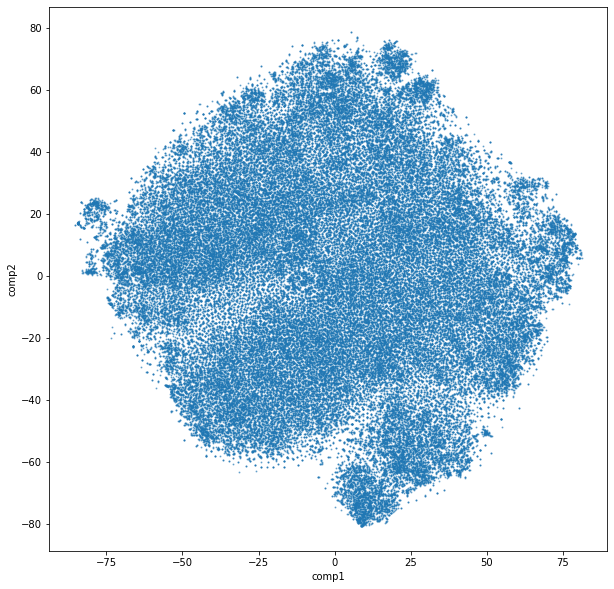

In [15]:
# plot the result

df_t25.plot(kind = 'scatter', x = 'comp1', y = 'comp2', s = 1, alpha = 0.5, figsize = (10, 10));

#### K-Means

In [11]:
# find the best k

scores = []

for k in range(2, 4):
    
    # cluster
    km = KMeans(n_clusters = k, random_state = 2020)
    km.fit(X_pca)
    
    # silhouette score
    sil = silhouette_score(X_pca, km.labels_)
    
    # append to a list
    scores.append((k, sil))

In [12]:
# store the score with k to a dataframe

k_scores = pd.DataFrame(scores, columns = ['k', 'sil'])

k_scores

,k,sil
0,2,0.116482
1,3,0.097303


In [109]:
# define number of clusters (2) and find centroids

km = KMeans(n_clusters = 2, random_state = 2020)
km.fit(X_pca)

KMeans(n_clusters=2, random_state=2020)

In [110]:
# find centroids

km.cluster_centers_

array([[-2.30791520e-01,  8.40894769e-03, -1.31805268e-02,
        -2.05200015e-03, -8.18309392e-04,  1.72260331e-03,
        -4.36161348e-03,  1.38884276e-03,  2.71338174e-04,
         6.41130976e-05, -2.47596584e-05,  4.19629002e-04,
         1.30807657e-03, -1.44804296e-03, -6.00596695e-04,
         4.51148154e-04, -8.67342668e-04,  3.11418135e-04,
         9.00332363e-04,  1.76385961e-03,  1.17347702e-03,
         4.65320795e-06,  3.30114816e-04,  3.17965316e-05,
        -2.54424046e-04,  5.15435750e-04, -4.21622661e-04,
         1.51888245e-04,  1.80293477e-04,  1.61924487e-04,
         7.10212253e-04, -1.77024470e-04,  4.97888902e-04,
        -1.08971464e-03, -3.20500797e-04,  6.38232527e-04,
         2.79641932e-04,  6.74985554e-04, -7.75865346e-04,
        -2.70476583e-04,  7.57032170e-05,  7.12469142e-04,
         5.01742613e-04, -2.27682957e-04, -3.62941246e-04,
         4.56674594e-05,  5.12055641e-04, -2.73007570e-04,
        -5.26751873e-05,  1.21095095e-04],
       [ 2.40

In [111]:
# find cluster centers

centroids = df.groupby('k_class').mean()

In [112]:
centroids

,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,k_class_tf
k_class,,,,,,,,
0,0.155595,0.247094,0.217794,0.270227,0.326031,235.244049,15.777916,0.224114
1,0.069100,0.378322,0.135550,0.291737,0.247752,180.612583,14.632860,0.066129


In [113]:
# class attributes

km.labels_.mean()

0.4882045652791799

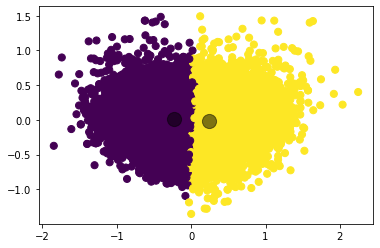

In [115]:
# visualize

k = km.predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c = k, s = 50, cmap = 'viridis')

centers = km.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5);

In [20]:
# assign clusters and store it in the dataset

df['k_class'] = km.labels_

In [21]:
df.head()

,subreddit,author,date,post,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,lemmatized,vectors,k_class
0,alcoholism,glorybellpirate,2020-01-01,Day 1 of sobriety Feeling anxious and letting ...,0,0,1,0,0,24,3,day 1 of sobriety feel anxious and let the fee...,"[-0.026765203100000003, 0.2515704036, -0.15668...",0
1,alcoholism,EhndlessSl0th,2020-01-01,"Started the New Year with a bang. Hey, I'm new...",0,1,1,0,1,577,41,start the new year with a bang hey -pron- be n...,"[0.0102483444, 0.18354494870000002, -0.2263026...",0
2,alcoholism,the_kinky_penguin,2020-01-01,Why can't I get drunk anymore I've been a heav...,0,0,1,0,0,64,5,why ca not -pron- get drunk anymore -pron- hav...,"[-0.09739924970000001, 0.1839587241, -0.227181...",0
3,alcoholism,SauceoffSauceOn,2020-01-01,I am an Alcoholic. How do I quit? I have been ...,0,0,1,0,1,111,14,-pron- be an alcoholic how do -pron- quit -pro...,"[-0.0117096035, 0.1865714192, -0.2576603591, -...",1
4,alcoholism,ben42187,2020-01-01,Funniest Thing about Alcoholism With every oth...,0,0,1,0,0,136,9,funniest thing about alcoholism with every oth...,"[-0.0443742387, 0.1812106818, -0.1554362029000...",0


#### Feature Agglomerative Clustering

In [23]:
# instantiate feature agglomerative clustering
# with clusters: 2

fa = FeatureAgglomeration(n_clusters = 2)

# fit model and predict clusters

X_fa = fa.fit_transform(X_pca)

In [24]:
X_fa.shape

(102031, 2)

In [26]:
X_fa[:5]

array([[ 0.03946312, -0.69460721],
       [-0.00164312, -0.02467937],
       [-0.00110124, -0.09072182],
       [ 0.00987699,  0.02668293],
       [ 0.00811135, -0.3236834 ]])

In [35]:
fa.labels_

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [34]:
# print the result

for i, label in enumerate(set(fa.labels_)):
    
    features_with_label = [j for j, lab in enumerate(fa.labels_) if lab == label]
    
    print(f'Features in agglomeration {i}: \n{features_with_label}')

Features in agglomeration 0: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Features in agglomeration 1: 
[0]


In [51]:
# instantiate feature agglomerative clustering
# with clusters: 10

fa_10 = FeatureAgglomeration(n_clusters = 10)

# fit model and predict clusters

X_fa_10 = fa_10.fit_transform(X_pca)

In [52]:
X_fa_10.shape

(102031, 10)

In [53]:
X_fa_10[:5]

array([[ 1.70514532e-02, -2.00329060e-01,  1.43210906e-01,
        -8.97472485e-02,  3.35165583e-01,  1.69133963e-01,
         4.95264362e-01, -6.94607208e-01,  1.63382481e-01,
         2.18502345e-01],
       [-3.96087944e-03,  7.37292403e-02,  1.29123027e-01,
        -1.00994705e-01,  1.28077204e-01,  2.75816764e-01,
         5.58184262e-02, -2.46793704e-02, -1.61268563e-01,
        -3.18418396e-01],
       [-4.06006382e-03,  1.68169650e-01, -8.26649054e-02,
        -5.38661153e-02,  4.93986166e-04,  9.89595796e-02,
        -3.22565421e-02, -9.07218207e-02,  8.59575705e-02,
        -7.22914515e-02],
       [ 8.57448689e-03,  6.08340090e-02,  1.23468141e-02,
        -7.15259395e-03, -9.06958227e-02, -3.24570235e-03,
        -3.86253718e-01,  2.66829267e-02,  1.90606781e-01,
         3.55979022e-01],
       [-1.76604781e-03,  1.29217736e-01, -1.25796501e-01,
        -1.58005854e-01,  7.49574361e-02,  4.15658477e-01,
         6.49321519e-02, -3.23683402e-01, -1.87148420e-02,
         8.

In [54]:
fa_10.labels_

array([7, 5, 9, 8, 6, 2, 3, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [55]:
# print the result

for i, label in enumerate(set(fa_10.labels_)):
    
    features_with_label = [j for j, lab in enumerate(fa_10.labels_) if lab == label]
    
    print(f'Features in agglomeration {i}: \n{features_with_label}')

Features in agglomeration 0: 
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Features in agglomeration 1: 
[8]
Features in agglomeration 2: 
[5]
Features in agglomeration 3: 
[6]
Features in agglomeration 4: 
[7]
Features in agglomeration 5: 
[1]
Features in agglomeration 6: 
[4]
Features in agglomeration 7: 
[0]
Features in agglomeration 8: 
[3]
Features in agglomeration 9: 
[2]


### with TF-IDF vectors

In [172]:
# import libraries

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer 

In [173]:
# set up X

X = df['lemmatized']

In [184]:
# update stop_words

remove = ['-pron-', 'feel', 'know', 'want', 'life', 'go', 'think', 'make', 'people', 'really', 'even', 'much', 'now', 
          'pron', 'don', 'will', 'try', 'talk', 'friends', 'tell', 'just', 'like', 'time', 'want', 'well', 'thing', 'day',
          'friend', 'help', 'year', 'bad', 've', 'say', 'good', 'need', 'way', 'right', 'month', 'amp x200b']

my_stop_words = text.ENGLISH_STOP_WORDS.union(remove)

#### Parameters 1:
max_features = 256, max_df = 0.8, min_df = 10, ngram_range = (1, 3)

In [175]:
# instantiate Tf-IDF

tvec = TfidfVectorizer(stop_words = my_stop_words, max_df = .80, min_df = 10, max_features = 256, ngram_range = (1, 3))

In [176]:
# fit/transform X then save it to a dataframe

t = pd.DataFrame(tvec.fit_transform(X).toarray(),
                 columns = tvec.get_feature_names())
t.head()

,10,20,able,act,actually,advice,afraid,ago,alive,amp,...,wo,wonder,word,work,world,worry,worth,write,wrong,young
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088334,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.4068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.389289,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [177]:
# get count of common words

# empty dictionary

common = {}

# loop through columns

for col in t.columns:
    
    # save sum of each column in dictionary
    common[col] = t[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common = pd.DataFrame(sorted(common.items(), key = lambda x: x[1], reverse = True))

In [178]:
# find top 20 words

most_common[:20]

,0,1
0,anxiety,4812.178410
1,work,4142.625446
2,depression,3743.184357
3,start,3715.468362
4,ca,3628.760631
5,live,3411.159799
6,anymore,3282.907686
7,love,3218.627868
8,end,3080.022460
9,die,3056.550669


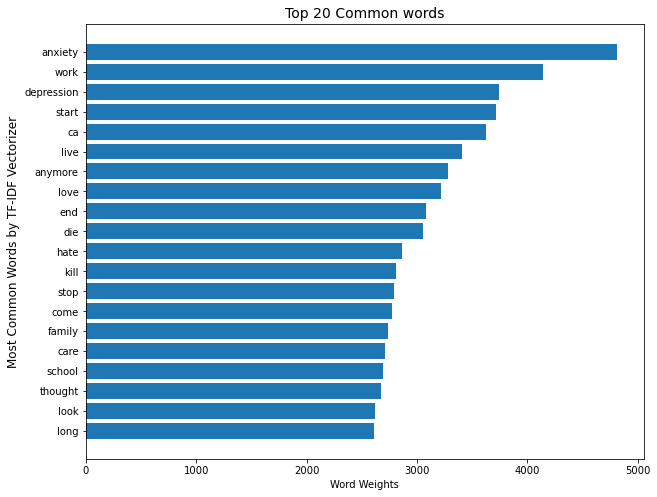

In [179]:
# plot top 20 words 

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common[0][:20], most_common[1][:20], align = 'center')

ax.set_yticks(most_common.index[:20])
ax.set_yticklabels(most_common[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Word Weights')
ax.set_ylabel('Most Common Words by TF-IDF Vectorizer', size = 12)
ax.set_title('Top 20 Common words', size = 14)

plt.savefig('../images/top20_tf.png');

In [87]:
# first reduce dimensionality with PCA before feeding to t-sne

pca = PCA(n_components = 10)
t_pca = pca.fit_transform(t) 

#### t-sne

In [88]:
# reduce dimensionality again with t-sne (perplexity = 5.0 -- half of components number after PCA)

tsne_5t = TSNE(n_components = 2, perplexity = 5.0, n_iter = 1000, verbose = 1).fit_transform(t_pca)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 102031 samples in 0.111s...
[t-SNE] Computed neighbors for 102031 samples in 25.800s...
[t-SNE] Computed conditional probabilities for sample 1000 / 102031
[t-SNE] Computed conditional probabilities for sample 2000 / 102031
[t-SNE] Computed conditional probabilities for sample 3000 / 102031
[t-SNE] Computed conditional probabilities for sample 4000 / 102031
[t-SNE] Computed conditional probabilities for sample 5000 / 102031
[t-SNE] Computed conditional probabilities for sample 6000 / 102031
[t-SNE] Computed conditional probabilities for sample 7000 / 102031
[t-SNE] Computed conditional probabilities for sample 8000 / 102031
[t-SNE] Computed conditional probabilities for sample 9000 / 102031
[t-SNE] Computed conditional probabilities for sample 10000 / 102031
[t-SNE] Computed conditional probabilities for sample 11000 / 102031
[t-SNE] Computed conditional probabilities for sample 12000 / 102031
[t-SNE] Computed conditional probab

In [90]:
# create a dataframe with the result

t_t5 = pd.DataFrame(tsne_5t, columns = ['comp1', 'comp2'])

t_t5

,comp1,comp2
0,12.945778,35.650608
1,1.259279,-9.433947
2,16.260641,28.369703
3,5.206892,46.877850
4,-11.053144,-2.954678
...,...,...
102026,7.703794,-48.824577
102027,46.946983,5.493317
102028,43.046200,-5.699484
102029,-2.456550,-29.922312


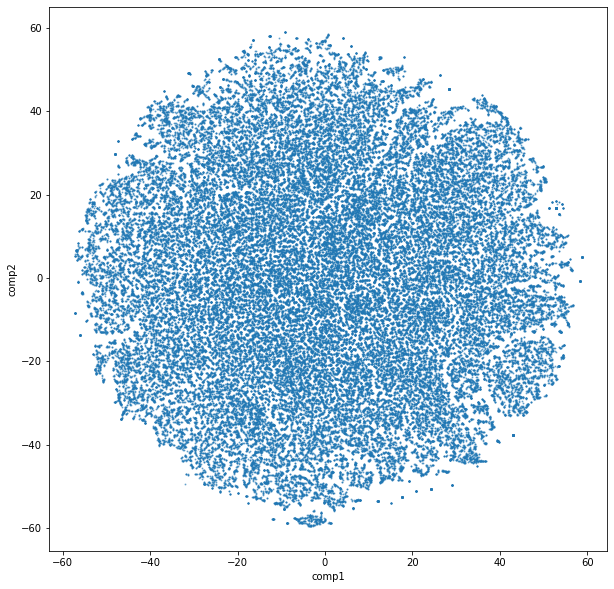

In [92]:
# plot the result

t_t5.plot(kind = 'scatter', x = 'comp1', y = 'comp2', s = 1, alpha = 0.5, figsize = (10, 10));

#### KMeans

In [93]:
# find the best k

scores = []

for k in range(2, 4):
    
    # cluster
    km = KMeans(n_clusters = k, random_state = 2020)
    km.fit(t_pca)
    
    # silhouette score
    sil = silhouette_score(t_pca, km.labels_)
    
    # append to a list
    scores.append((k, sil))

In [94]:
# store the score with k to a dataframe

k_scores = pd.DataFrame(scores, columns = ['k', 'sil'])

k_scores

,k,sil
0,2,0.218170
1,3,0.143844


In [123]:
# define number of clusters (2) and find centroids

k = KMeans(n_clusters = 2, random_state = 2020)
k.fit(t_pca)

KMeans(n_clusters=2, random_state=2020)

In [124]:
# find centroids

k.cluster_centers_

array([[-4.32718709e-02,  6.06334913e-03,  1.31270097e-02,
        -3.30624912e-03,  5.31298881e-03,  4.86026913e-03,
        -2.49950310e-03,  6.63156430e-04,  1.16409730e-03,
        -1.05379046e-04],
       [ 2.50244434e-01, -3.50647970e-02, -7.59144691e-02,
         1.91202835e-02, -3.07254077e-02, -2.81072963e-02,
         1.44548115e-02, -3.83508275e-03, -6.73206090e-03,
         6.09414827e-04]])

In [125]:
# store labels in the dataframe

df['k_class_tf'] = k.labels_

In [126]:
# find cluster centers

centroids = df.groupby('k_class_tf').mean()

In [127]:
centroids

,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,k_class
k_class_tf,,,,,,,,
0,0.105568,0.346554,0.17939,0.296378,0.293989,208.584473,15.341108,0.534481
1,0.158632,0.105754,0.16750,0.189905,0.251984,208.504501,14.509635,0.219644


In [128]:
# class attributes

k.labels_.mean()

0.14698473993198147

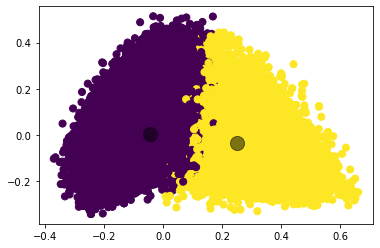

In [129]:
# visualize

k_tf = k.predict(t_pca)

plt.scatter(t_pca[:, 0], t_pca[:, 1], c = k_tf, s = 50, cmap = 'viridis')

centers = k.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5);

#### Parameter 2:
max_features = 256, max_df = 0.8, min_df = 10, ngram_range = (2, 2)

In [185]:
# instantiate Tf-IDF

tvec_2 = TfidfVectorizer(stop_words = my_stop_words, max_df = .80, min_df = 10, max_features = 256, ngram_range = (2, 2))

In [197]:
# fit/transform X then save it to a dataframe

t = pd.DataFrame(tvec_2.fit_transform(X).toarray(),
                 columns = tvec_2.get_feature_names())
t.head()

,10 minute,17 old,18 old,19 old,20 old,30 minute,actually care,advice appreciate,ago start,amp x200b,...,wish dead,wo able,work hard,work home,work job,work school,work week,work work,worth live,young age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
# get count of common words

# empty dictionary

common = {}

# loop through columns

for col in t.columns:
    
    # save sum of each column in dictionary
    common[col] = t[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common = pd.DataFrame(sorted(common.items(), key = lambda x: x[1], reverse = True))

In [199]:
# find top 20 words

most_common[:20]

,0,1
0,mental health,3111.780384
1,panic attack,2474.099765
2,high school,1729.964153
3,suicidal thought,1532.690332
4,self harm,1340.753826
5,depression anxiety,1260.845330
6,amp x200b,1143.509860
7,commit suicide,1088.595480
8,anxiety depression,1038.184367
9,social anxiety,1029.654295


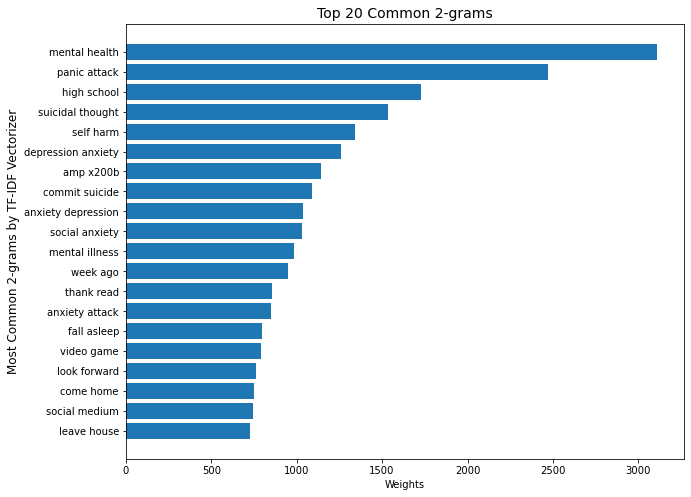

In [211]:
# plot top 20 words 

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common[0][:20], most_common[1][:20], align = 'center')

ax.set_yticks(most_common.index[:20])
ax.set_yticklabels(most_common[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Weights')
ax.set_ylabel('Most Common 2-grams by TF-IDF Vectorizer', size = 12)
ax.set_title('Top 20 Common 2-grams', size = 14)

plt.savefig('../images/top20_2gram.png');

In [203]:
# find the best k

scores = []

for k in range(2, 10):
    
    # cluster
    km = KMeans(n_clusters = k, random_state = 2020)
    km.fit(t)
    
    # silhouette score
    sil = silhouette_score(t, km.labels_)
    
    # append to a list
    scores.append((k, sil))

In [204]:
# store the score with k to a dataframe

k_scores = pd.DataFrame(scores, columns = ['k', 'sil'])

k_scores

,k,sil
0,2,0.192476
1,3,0.200113
2,4,0.200644
3,5,0.204348
4,6,0.205346
5,7,0.209806
6,8,0.214032
7,9,0.218767


In [205]:
# define number of clusters (2) and find centroids

k = KMeans(n_clusters = 2, random_state = 2020)
k.fit(t)

KMeans(n_clusters=2, random_state=2020)

In [206]:
# find centroids

k.cluster_centers_

array([[1.64080302e-03, 1.67079891e-03, 2.03013397e-03, 2.08714869e-03,
        2.02015462e-03, 1.40391264e-03, 1.33266582e-03, 4.49594629e-03,
        1.64774843e-03, 1.07179236e-02, 2.70421601e-03, 3.07588217e-03,
        1.10476466e-03, 6.77921020e-03, 1.14253125e-03, 8.79682212e-04,
        1.98971386e-02, 4.93296512e-03, 1.96584413e-03, 2.79113260e-03,
        1.62989746e-03, 9.61272089e-04, 2.64717752e-03, 5.28393295e-03,
        5.54337945e-03, 2.46987817e-03, 3.26190762e-03, 1.19374680e-03,
        2.08088802e-03, 2.92911729e-03, 2.98799978e-03, 2.84070300e-03,
        1.13966537e-03, 1.63371334e-03, 3.24532056e-03, 2.17366957e-03,
        2.00508797e-03, 2.17491527e-03, 1.45563217e-03, 3.18297193e-03,
        2.72269481e-03, 1.78360531e-03, 1.58218235e-03, 7.09068400e-04,
        1.25285873e-03, 1.50177617e-03, 3.21599117e-03, 6.09969161e-03,
        7.50295697e-03, 7.95285222e-04, 4.75738907e-03, 1.64296543e-03,
        4.77413285e-03, 5.06792000e-03, 1.14807757e-02, 2.818176

In [207]:
# store labels in the dataframe

df['k_tf256_2gram'] = k.labels_

In [208]:
# find cluster centers

centroids = df.groupby('k_tf256_2gram').mean()

In [209]:
centroids

,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences
k_tf256_2gram,,,,,,,
0,0.176573,0.306941,0.223644,0.312364,0.393492,277.617354,18.495879
1,0.110377,0.311360,0.175465,0.279231,0.282814,205.305499,15.063826


In [210]:
# class attributes

k.labels_.mean()

0.9548176534582626

#### Parameter 3:
max_features = 256, max_df = 0.8, min_df = 10, ngram_range = (3, 3)

In [192]:
# instantiate Tf-IDF

tvec_3 = TfidfVectorizer(stop_words = my_stop_words, max_df = .80, min_df = 10, max_features = 256, ngram_range = (3, 3))

In [193]:
# fit/transform X then save it to a dataframe

t = pd.DataFrame(tvec_3.fit_transform(X).toarray(),
                 columns = tvec_3.get_feature_names())
t.head()

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amp', 'x200b'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,20 old male,40 hour week,advice appreciate thank,advice greatly appreciate,affect mental health,ago panic attack,amp utm medium,amp x200b amp,amp x200b sorry,amp x200b thank,...,work mental health,work minimum wage,worth live anymore,worthless piece shit,write suicide note,www ncbi nlm,www reddit com,www youtube com,x200b amp x200b,youtube com watch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
# get count of common words

# empty dictionary

common = {}

# loop through columns

for col in t.columns:
    
    # save sum of each column in dictionary
    common[col] = t[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common = pd.DataFrame(sorted(common.items(), key = lambda x: x[1], reverse = True))

In [195]:
# find top 20 words

most_common[:20]

,0,1
0,play video game,716.605171
1,mental health issue,665.314246
2,long story short,622.003325
3,anxiety panic attack,345.597256
4,low self esteem,300.701722
5,graduate high school,226.574274
6,struggle mental health,222.408310
7,start new job,215.162486
8,sorry long post,211.337727
9,mental health problem,210.776215


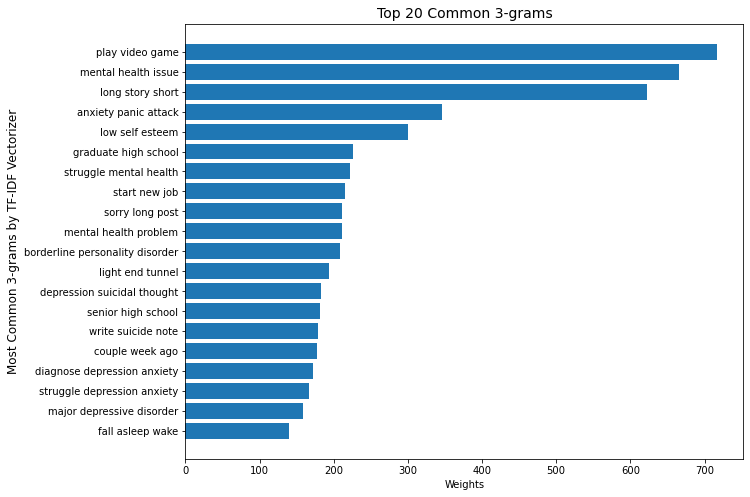

In [196]:
# plot top 20 words 

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common[0][:20], most_common[1][:20], align = 'center')

ax.set_yticks(most_common.index[:20])
ax.set_yticklabels(most_common[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Weights')
ax.set_ylabel('Most Common 3-grams by TF-IDF Vectorizer', size = 12)
ax.set_title('Top 20 Common 3-grams', size = 14)

plt.savefig('../images/top20_3gram.png');

In [131]:
# find the best k

scores = []

for k in range(2, 4):
    
    # cluster
    km = KMeans(n_clusters = k, random_state = 2020)
    km.fit(t)
    
    # silhouette score
    sil = silhouette_score(t, km.labels_)
    
    # append to a list
    scores.append((k, sil))

In [132]:
# store the score with k to a dataframe

k_scores = pd.DataFrame(scores, columns = ['k', 'sil'])

k_scores

,k,sil
0,2,0.732076
1,3,0.736386


In [134]:
# define number of clusters (2) and find centroids

k = KMeans(n_clusters = 2, random_state = 2020)
k.fit(t)

KMeans(n_clusters=2, random_state=2020)

In [135]:
# find centroids

k.cluster_centers_

array([[ 4.97074162e-04,  5.15288509e-04,  6.40782903e-04,
         1.27074803e-03,  9.03810658e-04,  5.54787042e-04,
         2.91332390e-04,  7.02943174e-04,  5.55327655e-04,
         1.11954651e-03,  5.50208986e-04,  5.45282420e-04,
         7.12492872e-04,  3.39369565e-03,  5.92275285e-04,
         7.12951455e-04,  7.68155504e-04,  4.91029721e-04,
         9.26715341e-04,  7.62861218e-04,  2.02586175e-03,
         5.58494634e-04,  4.92345997e-04,  6.66495238e-04,
         2.03340999e-04,  4.36530865e-04,  4.85731521e-04,
         8.39235142e-04,  4.12359108e-04,  6.27492815e-04,
         7.16193005e-04,  4.67254827e-04,  4.77270909e-04,
         6.54764479e-04,  3.94911816e-04,  6.09602181e-04,
         2.24601081e-04,  5.28107894e-04,  1.12199926e-03,
         5.96797158e-04,  6.33620592e-04,  4.02179804e-04,
         1.73091039e-03,  6.50443121e-04,  9.82309717e-04,
         6.42226679e-04,  9.21436261e-04,  7.03647384e-04,
         9.40796521e-04,  5.20320843e-04,  4.48531336e-0

In [136]:
# store labels in the dataframe

df['k_tf256'] = k.labels_

In [137]:
# find cluster centers

centroids = df.groupby('k_tf256').mean()

In [138]:
centroids

,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,k_class,k_class_tf
k_tf256,,,,,,,,,
0,0.112976,0.310738,0.176726,0.280259,0.286229,207.329406,15.146257,0.489763,0.146721
1,0.171554,0.373900,0.313783,0.350440,0.523460,393.335777,26.013196,0.256598,0.186217


In [139]:
# class attributes

k.labels_.mean()

0.006684243024178926

In [142]:
# reduce dimensionality with PCA

pca = PCA(n_components = 10)
t_pca = pca.fit_transform(t) 

In [143]:
# find the best k

scores = []

for k in range(2, 4):
    
    # cluster
    km = KMeans(n_clusters = k, random_state = 2020)
    km.fit(t_pca)
    
    # silhouette score
    sil = silhouette_score(t_pca, km.labels_)
    
    # append to a list
    scores.append((k, sil))

In [144]:
# store the score with k to a dataframe

k_scores = pd.DataFrame(scores, columns = ['k', 'sil'])

k_scores

,k,sil
0,2,0.935467
1,3,0.944915


In [146]:
# define number of clusters (2) and find centroids

k = KMeans(n_clusters = 2, random_state = 2020)
k.fit(t_pca)

KMeans(n_clusters=2, random_state=2020)

In [147]:
# find centroids

k.cluster_centers_

array([[-6.94792675e-03, -1.88171472e-04, -1.42299252e-04,
        -1.86012455e-05, -2.18334648e-06, -9.13222721e-06,
        -8.64920500e-06, -1.18258261e-05, -6.68659151e-06,
        -2.99408722e-06],
       [ 8.54417705e-01,  2.31402896e-02,  1.74991770e-02,
         2.28747855e-03,  2.68495906e-04,  1.12303093e-03,
         1.06363152e-03,  1.45427486e-03,  8.22280138e-04,
         3.68196329e-04]])

In [148]:
# store labels in the dataframe

df['k_tf10'] = k.labels_

In [151]:
# find cluster centers

centroids = df.groupby('k_tf10').mean()

In [152]:
centroids

,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,k_class,k_class_tf,k_tf256
k_tf10,,,,,,,,,,
0,0.112758,0.310776,0.176587,0.278960,0.286351,206.945518,15.115574,0.48841,0.147567,0.006689
1,0.188335,0.358445,0.307412,0.498177,0.467801,408.676792,27.924666,0.46294,0.075334,0.006075


In [153]:
# class attributes

k.labels_.mean()

0.008066175966127942

In [154]:
# define number of clusters (3) and find centroids

k = KMeans(n_clusters = 3, random_state = 2020)
k.fit(t_pca)

KMeans(n_clusters=3, random_state=2020)

In [155]:
# find centroids

k.cluster_centers_

array([[-6.77354074e-03, -6.19381469e-03, -7.56054722e-05,
        -2.25128682e-05, -7.74905822e-06, -9.43663334e-06,
        -1.43734775e-05, -1.71187990e-05, -1.59819463e-05,
        -8.45941497e-06],
       [ 8.55969874e-01,  1.92624573e-02,  1.76120346e-02,
         2.30171856e-03,  2.80610798e-04,  3.90473413e-04,
         9.51108242e-04,  1.42484226e-03,  8.69607061e-04,
         3.68192441e-04],
       [-2.82001943e-02,  8.89902778e-01, -9.97939973e-03,
         5.57823130e-04,  8.05690527e-04,  9.22678789e-04,
         9.77967040e-04,  8.14441372e-04,  1.31281887e-03,
         8.05354881e-04]])

In [156]:
# store labels in the dataframe

df['k_tf10_3'] = k.labels_

In [158]:
# find cluster centers

centroids = df.groupby('k_tf10_3').mean()

In [159]:
centroids

,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,k_class,k_class_tf,k_tf256,k_tf10
k_tf10_3,,,,,,,,,,,
0,0.112353,0.310342,0.175667,0.278471,0.284778,205.704648,15.043081,0.489968,0.147298,0.0,0.000000
1,0.189487,0.359413,0.306846,0.500000,0.464548,407.009780,27.826406,0.464548,0.075795,0.0,1.000000
2,0.171554,0.373900,0.313783,0.350440,0.523460,393.335777,26.013196,0.256598,0.186217,1.0,0.007331


In [160]:
# class attributes

k.labels_.mean()

0.021385657300232282

In [162]:
df.groupby('k_tf10_3').count()

,subreddit,author,date,post,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,lemmatized,vectors,k_class,color,k_class_tf,k_tf256,k_tf10
k_tf10_3,,,,,,,,,,,,,,,,,,
0,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531,100531
1,818,818,818,818,818,818,818,818,818,818,818,818,818,818,818,818,818,818
2,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682


### with word2vec

In [75]:
## import libaries 
# word2vec

import gensim

# faster looping

from itertools import islice

# create own warning sign

import logging

In [76]:
# create word2vec model

file_path = '/Users/juhee/Desktop/GA/08-week/8.05-lesson-word-vectors/lexvec.enwiki+newscrawl.300d.W.pos.vectors'

w2v = gensim.models.KeyedVectors.load_word2vec_format(file_path)

In [77]:
# precompute l2 normalized vectors 

w2v.init_sims(replace = True)

# check the vocabulary index between 13030 and 13048 in w2v model

list(islice(w2v.vocab, 13030, 13048))

['bal',
 'harley',
 'proponents',
 'escalating',
 'madeleine',
 'crushing',
 'yielded',
 'understandable',
 'agnes',
 'victorious',
 'rockefeller',
 'deeds',
 'jude',
 'doomed',
 'sundays',
 'rejecting',
 'prep',
 'concession']

In [80]:
# average word vectors

def word_averaging(model, words):
    
    # store all words from posts as a set to filter duplicates and average in a list
    
    all_words, mean = set(), []
    
    for word in words:
        
        # word is in an array form (vector arrays), then append it to mean
        
        if isinstance(word, np.ndarray):
            mean.append(word)
        
        # word is in model vocabulary, append it to mean, and add it to the words set
        
        elif word in model.vocab:
            mean.append(model.syn0norm[model.vocab[word].index])
            all_words.add(model.vocab[word].index)
    
    # word cannot be computated to vectoris, generate a warning and fill it with 0
    
    if not mean:
        logging.warning('cannot compute similarity with no input %s', words)
        return np.zeros(model.vector_size, )
    
    # scale vectors to unit length
    
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis = 0)).astype(np.float32)
    
    return mean

def word_averaging_list(model, text_list):
    
    # stack the arrays vertically
    
    return np.vstack([word_averaging(model, post) for post in text_list])

In [87]:
# create a function to tokenize

def w2v_tokenize_text(text):
    
    # store tokes in a list
    
    tokens = []
    
    # iterate through every sentence in a post
    
    for sent in nltk.sent_tokenize(text.lower(), language = 'english'):
        
        # iterate through every word in a sentence
        
        for word in nltk.word_tokenize(sent, language = 'english'):
            
            # discard 1 letter words
            
            if len(word) < 2:
                continue
            
            # add word to the token list
            
            tokens.append(word)
    
    return tokens

In [88]:
# tokenize

tokenized = df.apply(lambda r: w2v_tokenize_text(r['post']), axis = 1).values

In [89]:
tokenized[0]

['day',
 'of',
 'sobriety',
 'feeling',
 'anxious',
 'and',
 'letting',
 'the',
 'feelings',
 'flow',
 'why',
 'is',
 'alcohol',
 'everywhere',
 'on',
 'tv',
 'breathe',
 'through',
 'it']

In [90]:
# get the word average

word_average = word_averaging_list(w2v, tokenized)

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).


In [92]:
# get information of vectors

print(len(word_average))
print(len(word_average[0]))

102031
300


In [94]:
# store word_average in a dataframe

w2vecs = pd.DataFrame(word_average, columns = list(range(1, 301)))

In [96]:
# find the best k

scores = []

for k in range(2, 10):
    
    # cluster
    km = KMeans(n_clusters = k, random_state = 2020)
    km.fit(w2vecs)
    
    # silhouette score
    sil = silhouette_score(w2vecs, km.labels_)
    
    # append to a list
    scores.append((k, sil))

In [97]:
# store the score with k to a dataframe

k_scores = pd.DataFrame(scores, columns = ['k', 'sil'])

k_scores

,k,sil
0,2,0.084775
1,3,0.048786
2,4,0.027325
3,5,0.017794
4,6,0.007831
5,7,0.016926
6,8,0.009353
7,9,0.008469


In [98]:
# reduce dimensionality again with t-sne (perplexity = 25.0)

tsne_25w = TSNE(n_components = 2, perplexity = 25.0, n_iter = 2000, verbose = 1).fit_transform(w2vecs)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 102031 samples in 3.343s...
[t-SNE] Computed neighbors for 102031 samples in 5929.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 102031
[t-SNE] Computed conditional probabilities for sample 2000 / 102031
[t-SNE] Computed conditional probabilities for sample 3000 / 102031
[t-SNE] Computed conditional probabilities for sample 4000 / 102031
[t-SNE] Computed conditional probabilities for sample 5000 / 102031
[t-SNE] Computed conditional probabilities for sample 6000 / 102031
[t-SNE] Computed conditional probabilities for sample 7000 / 102031
[t-SNE] Computed conditional probabilities for sample 8000 / 102031
[t-SNE] Computed conditional probabilities for sample 9000 / 102031
[t-SNE] Computed conditional probabilities for sample 10000 / 102031
[t-SNE] Computed conditional probabilities for sample 11000 / 102031
[t-SNE] Computed conditional probabilities for sample 12000 / 102031
[t-SNE] Computed conditional prob

In [99]:
# create a dataframe with the result

w_t25 = pd.DataFrame(tsne_25t, columns = ['comp1', 'comp2'])

w_t25

,comp1,comp2
0,1.724401,-15.326765
1,-15.280069,36.796116
2,-72.669128,-23.114244
3,-68.844238,-21.800100
4,-16.551222,-16.378727
...,...,...
102026,38.655075,-61.135464
102027,-7.078886,-37.650429
102028,71.883911,-0.113963
102029,30.489517,-31.182003


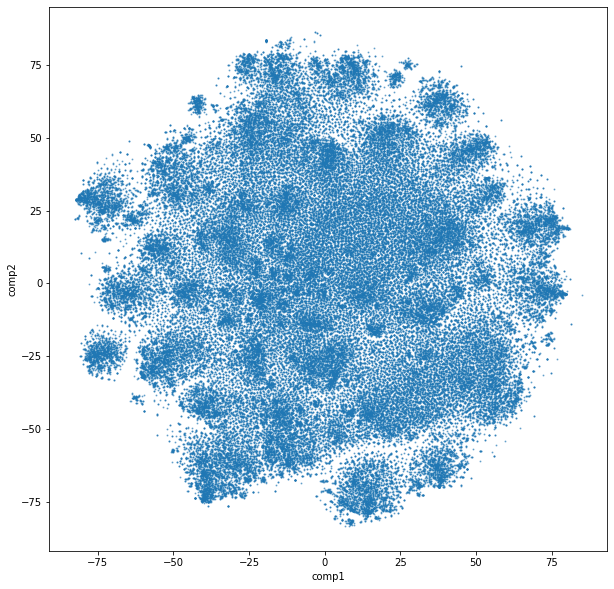

In [100]:
# plot the result

t_t25.plot(kind = 'scatter', x = 'comp1', y = 'comp2', s = 1, alpha = 0.5, figsize = (10, 10));

In [101]:
# train test split

train, test = train_test_split(df[['suicidal', 'post']], test_size = 0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis = 1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis = 1).values

In [102]:
X_train_word_average = word_averaging_list(w2v, train_tokenized)
X_test_word_average = word_averaging_list(w2v, test_tokenized)

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).


In [105]:
# support vector machine

svc = SVC()
svc = svc.fit(X = X_train_word_average, y = train['suicidal'])
y_pred = svc.predict(X_test_word_average)

In [106]:
print('accuracy %s' % accuracy_score(y_pred, test['suicidal']))

accuracy 0.8283567461613852


In [111]:
print(classification_report(test['suicidal'], y_pred, target_names = ['Non-suicidal', 'Suicidal']))

              precision    recall  f1-score   support

Non-suicidal       0.83      0.94      0.88     21127
    Suicidal       0.81      0.58      0.68      9483

    accuracy                           0.83     30610
   macro avg       0.82      0.76      0.78     30610
weighted avg       0.83      0.83      0.82     30610

